# Hearing Protection Effectiveness Testing

## Goal
Outr goal here is to determine whether a hearing protection device (HPD) is effective and, evaluate it’s effectiveness at attenuating sound.

## Overview
The algorithms for the testing of HPD are laid out in CSA Z94.2-14, section 9.6. The result is one number—the ***Noise Reduction Rating*** (NRR)—which describes the device’s efficacy.

The test procedure is to play pink noise of a known level (100dB) at a dummy head wearing a set of the HPDs, and compare this to the noise level at an unprotected ear. The incoming signals are seperated into octave bands for analysis, and the noise levels are both A- and C-weighted to perform the calculations. The mean and standard deviation of multiple trials is needed to get an accurate result. This project will involve using the Fourier transform, windowing, filtering and separating the FFT into octave bands. 

In [1]:
import numpy as np
from numpy import fft
import scipy.io.wavfile
import matplotlib.pyplot as plt
from scipy import signal

# Misc Global Funcions
def normalize(sig):
    return sig/np.max(np.abs(sig))
def getRMS(sig):
    return np.sqrt(1/float(len(sig)) * np.sum(sig**2))
def db(x, xref=None):
    x = abs(x)
    if xref:
        return 20 * np.log10(x/xref)
    return 20 * np.log10(x)
def db_inv(y, xref = None):
    if xref:
        return xref * (10**(y/20))
    return (10**(y/20))

## Making a Test Sound File

Let's make sample noise files to verify whether the octave filter works, and whether we're calculating the NRR properly

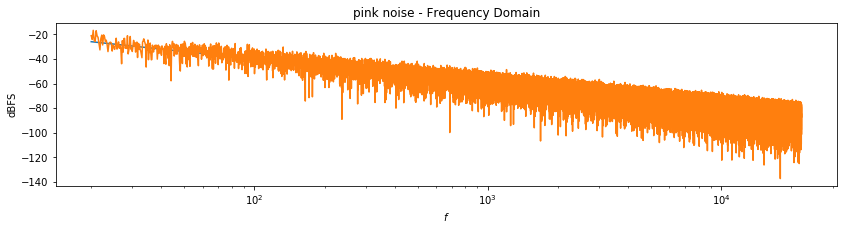

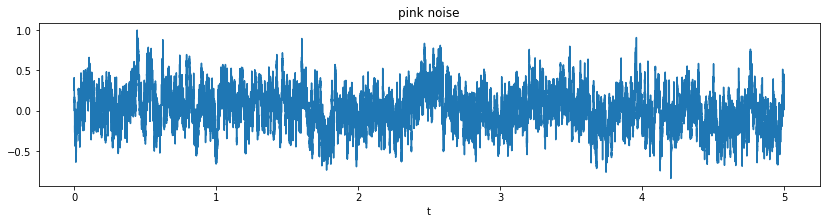

In [2]:
def noise_signal(L, fs, scale, color=None, export=None, plot=None):
    dt = 1/float(fs)
    nSamples = L * fs
    fmin = 20 #Hz
    fmax = fs/2 #Hz

    f = np.linspace(fmin,fmax, nSamples//2+1)
    
    if not(color) or color == "white":
        dist = np.ones(f.shape)
    if color == "pink":
        dist = pinkPower(f)
    if color == "red":
        dist = redPower(f)
    
    np.random.seed(1)
    SIG = np.zeros(nSamples//2+1, dtype=np.complex)
    SIG.real = np.random.normal(0,1, f.shape) * dist
    SIG.imag = np.random.normal(0,1, f.shape) * dist
    
#     print len(SIG)

    if scale > 1:
        scale = 1
    if scale < 0:
        scale = 0
        
    sig = scale*normalize(np.real(fft.irfft((SIG))))
    t = np.linspace(0, L, nSamples)
    
#     SIG = np.fft.rfft(sig)

#     print len(sig)
#     print len(t)

    if plot:
        plt.figure(figsize=(14,3))
        plt.title(color + " noise - Frequency Domain")
        plt.semilogx(f, db(dist))
        plt.semilogx(f, db(SIG))
        plt.xlabel("$f$")
        plt.ylabel("dBFS")
    
    if plot:
        plt.figure(figsize=(14,3))
        plt.title(color + " noise")
        plt.plot(t, sig)
        plt.xlabel("t")
    
    if export:
        scipy.io.wavfile.write(color+" noise at " + str(scale) + "x scale " + str(L) + " seconds.wav", fs, sig)
        
    return sig, SIG
    
def pinkPower(f):
    return 1/f
def redPower(f):
    return 1/(f**2)

L = 5 # seconds
fs = 44100
t = np.linspace(0, L, int(L*fs)+1)
f = np.linspace(20,fs/2, int(2*L*fs))

white, WHITE = noise_signal(L, fs, scale = 1, color="white", export=True, plot=False)
pink, PINK = noise_signal(L, fs, scale = 1, color="pink", export=True, plot=True)
pink, PINK = noise_signal(L, fs, scale = 0.5, color="pink", export=True, plot=False)
red, RED = noise_signal(L, fs, scale = 1, color="red", export=True, plot=False)
plt.show()

## Octave FIlter

Next we'll make an octave filter bank, configurable to the fraction of octave desired (i.e. for a third-octave bank, use `B=3`) and with a variable range and centre frequency. 

In calculating the NRR, we really only need single-octave filters though.

In [3]:
def OctaveBank(B, ny=None, octaves=None, centerFreq=None):
    if not(ny):
        ny = float(20000)
    if (octaves):
        K = range(-octaves/2*B, octaves/2*B)
    else:
        K = range(-4*B, 4*B)  
    
    if (centerFreq):
        f0 = centerFreq
    else: 
        f0 = 1000

    Bank = []
    Fc = [] 
    for k in K:
        fc = f0*2**((k)/float(B))
        Fc.append(fc)
        fl = fc/float(2**(1/float(2*B)))
        fu = fc*(2**(1/float(2*B)))
        [b, a] = signal.butter(2, [fl/ny, fu/ny], btype='band')
        Bank.append([b,a])
    return Bank, Fc

def ApplyFilterBank(Bank, x):
    y = [None] * len(Bank)
    P = np.zeros(len(Bank))
    for i, filt in enumerate(Bank):
        y[i] = (signal.filtfilt(filt[0], filt[1], x))
        P[i] = getRMS(y[i])
    return P

### Testing the Octave Bank
To show that the Octave filter bank is working, we'll find the octave power spectrum of a white noise signal. The expected result is a linearly decreacing function. I'll also plot the FFT of the test signal, which outputs a fairly messy result, since no windowing has been performed.

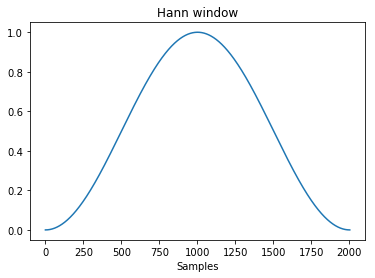

In [14]:
Ny = fs/2

# Now we'll apply a hann window to the 
frez = 22 #Hz - This is the lowest frequency we will pick up on the FFT
width = 1/float(frez) # seconds
hann = signal.hanning(width*fs, sym=False)
Lh = len(hann)

n_windows = int(2*(L/width) - 1)
windows = [None]*n_windows

plt.figure(figsize=(6,4))
plt.plot(hann, label="Window")
plt.title("Hann window")
plt.xlabel("Samples")
# plt.legend(loc="best")
plt.show();

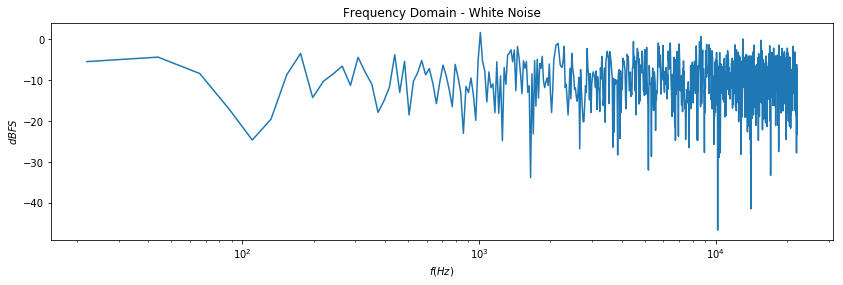

In [17]:
for i in range(0,n_windows):
    a = int(i*width/float(2) * fs) 
    b = int((i*width/float(2) + width) * fs)
    
    if b - a < len(hann):
        b +=  len(hann) - (b-a)
    windows[i] = white[a : b] * hann

#     plt.plot(windows[i], label="Windowed signal " + str(i))
    
WINDOWS = [None]*n_windows
plt.figure(figsize=(14,4))
freq = np.linspace(0, Ny, Lh/2+1)
for i in range(0,n_windows):
    WINDOWS[i] = np.fft.rfft(windows[i])

plt.semilogx(freq, db(np.mean(WINDOWS, axis=0)))

plt.title("Frequency Domain - White Noise")
plt.xlabel("$f (Hz)$")
plt.ylabel('$dBFS$')
plt.show();

This is technically correct—the best kind of correct. But it doesn't really tell us anythink about the signal, other than that it's noisy

In [8]:
Bank, Fc = OctaveBank(1, ny=Ny, octaves=8)    # Create the 1-octave filter bank

P_white = ApplyFilterBank(Bank, white)
P_pink = ApplyFilterBank(Bank, pink)
P_red = ApplyFilterBank(Bank, red)

In [65]:
def Plot8ve(P, Fc, Name=None):
    plt.figure(figsize=(14,4))
    plt.title("Octave Bands: " + str(Name))
    plt.bar(np.log10(Fc), db(P), width=0.25, edgecolor="k", tick_label=Fc)
    plt.xlabel("Band Centre Frequency (Hz)")
    plt.ylabel('$dBFS$')
    plt.show();

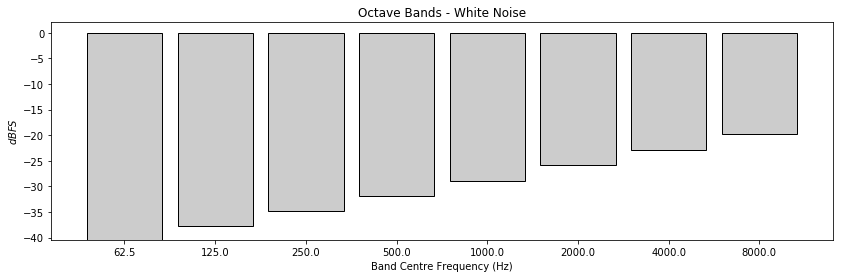

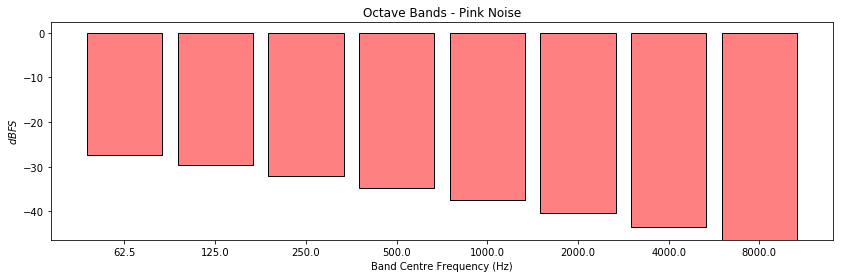

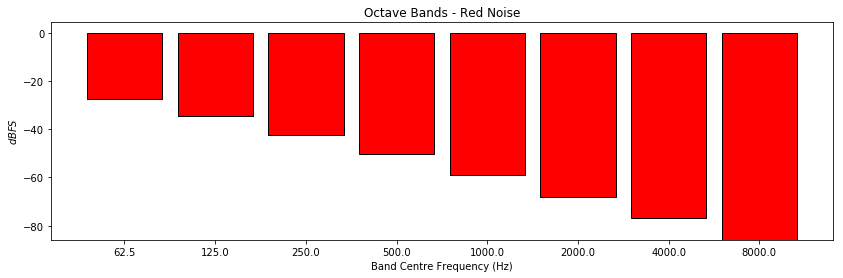

In [18]:
plt.figure(figsize=(14,4))
plt.title("Octave Bands - White Noise")
plt.bar(np.log10(Fc), db(P_white), width=0.25, edgecolor="k", tick_label=Fc, color="#cccccc")
plt.xlabel("Band Centre Frequency (Hz)")
plt.ylabel('$dBFS$')
plt.show();

plt.figure(figsize=(14,4))
plt.title("Octave Bands - Pink Noise")
plt.bar(np.log10(Fc), db(P_pink), width=0.25, edgecolor="k", tick_label=Fc, color="#ff8080")
plt.xlabel("Band Centre Frequency (Hz)")
plt.ylabel('$dBFS$')
plt.show();

plt.figure(figsize=(14,4))
plt.title("Octave Bands - Red Noise")
plt.bar(np.log10(Fc), db(P_red), width=0.25, edgecolor="k", tick_label=Fc, color="r")
plt.xlabel("Band Centre Frequency (Hz)")
plt.ylabel('$dBFS$')
plt.show();

Would you look at that! The Octave filters are behaving beautifully. 

## Sound Pressure Level (SPL) Weighting

[ 0.          0.61847825 -2.28936494  2.97265234 -1.36654999 -0.11978852
  0.18457286]
[ 1.         -4.23159338  7.0379046  -5.75002203  2.3400829  -0.42374449
  0.0273724 ]


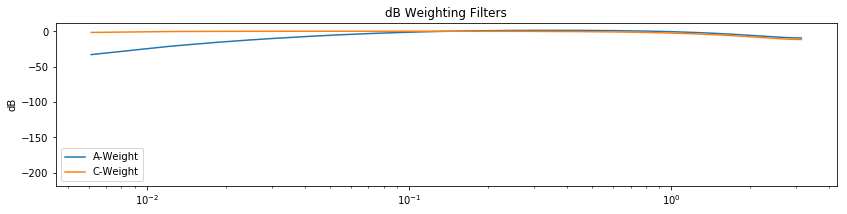

In [58]:
# See https://en.wikipedia.org/wiki/A-weighting
A_poles = [-129.4, -129.4, -676.7, -4636, -76555, -76555];
A_zeros =  [0, 0, 0, 0]
kA = 7.39705E9
C_poles = [-129.4, -129.4, -76655, -76655]
C_zeros =  [0, 0]
kC =  5.91797E9
bA, aA = scipy.signal.zpk2tf(A_zeros, A_poles, kA)
bC, aC = scipy.signal.zpk2tf(C_zeros, C_poles, kC)

sysA = [bA, aA]
sysC = [bC, aC]

baA = scipy.signal.cont2discrete(sysA, 1/float(fs), method="zoh")
baC = scipy.signal.cont2discrete(sysC, 1/float(fs), method="zoh")

print baA[0][0]
print baA[1]

wa, ha = scipy.signal.freqz(baA[0][0],baA[1])
wc, hc = scipy.signal.freqz(baC[0][0],baC[1])

plt.figure(figsize=(14,3))
plt.title("dB Weighting Filters")
plt.ylabel("dB")
plt.semilogx(wa, db(ha), label="A-Weight")
# plt.show()

# plt.figure(figsize=(14,3))
plt.semilogx(wc, db(hc), label="C-Weight")
plt.legend(loc="best")
plt.show()

# plt.figure(figsize=(14,3))
# plt.title("100dB Boost Filter")
# w, h = scipy.signal.freqs([db_inv(100)],[1])
# plt.ylabel("dB")
# plt.semilogx(w, db(h))
# plt.show()

In [59]:
def scale100dB(sig):
    return scipy.signal.lfilter([100],[1], sig)
def AWeight(sig):
    return scipy.signal.lfilter(baA[0][0],baA[1],sig)
def CWeight(sig):
    return scipy.signal.lfilter(baC[0][0],baC[1],sig)

In [60]:
A_adj = [-16.1, -8.6, -3.2, 0, 1.2, 1, -1.1]
C_adj = [-0.2, 0, 0, -0.2, -0.2, -0.8, -3]

In [68]:
def calcNRR(sig, ref):
    ref100 = scale100dB(ref)
    refC = CWeight(ref100)
    refA = AWeight(ref100)
    
    ref8ve = ApplyFilterBank(Bank, ref100)
    refC8ve = ApplyFilterBank(Bank, refC)
    refA8ve = ApplyFilterBank(Bank, refA)
    
    print ref8ve
    print refC8ve
    print refA8ve
        
calcNRR(pink,pink)
    

[ 4.22622825  3.33811933  2.49288866  1.84778149  1.32914165  0.95300994
  0.67374126  0.48010944]
[ 3.80562988  3.26885457  2.49229851  1.85608864  1.32935855  0.93356279
  0.61084912  0.33696934]
[ 0.22439417  0.52788222  0.92839246  1.25012855  1.30561426  1.08429878
  0.74920432  0.42001517]
